# Chapter 3
Chapter 3 is about Convolutional Neural Networks (CNNs) and data augmentation.

**Idea Convolutions:** Convolutions are tools to learn spatial patterns and can recognise simple patterns like horizontal or vertical lines. When stacking convolutions, they begin to recognise more complex patterns by building on top of the recognized simpler patterns.

In this chapter we will first learn to build our own convolutions and in the end learn about data augmentation techniques.

In [8]:
import torchvision
from torchvision import transforms
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import torch
import numpy as np

mnist_data_train = torchvision.datasets.MNIST(
    "./data", train=True, download=True, transform=transforms.ToTensor())
mnist_data_test = torchvision.datasets.MNIST(
    "./data", train=False, download=True, transform=transforms.ToTensor())

x_example, y_example = mnist_data_train[0]
type(x_example)  # returns PIL image without transform

torch.Tensor

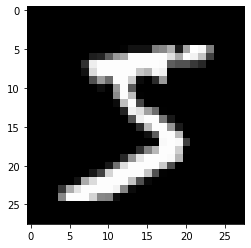

In [9]:
imshow(x_example[0,:], cmap="gray")

torch.Size([3, 28, 28])


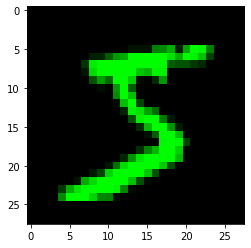

In [8]:
# stack the same image on each other to create an image with three channels
x_as_color = torch.stack([x_example[0,:],x_example[0,:],x_example[0,:]], dim=0)
print(x_as_color.shape)

# if we want to show the image, we need to permute the dimensions. (imshow needs W,H,C)
imshow(x_as_color.permute(1,2,0))

# still black and white since we stacked the same channels three times
# change the channels (zero out)
x_as_color[0,:] = 0
x_as_color[2,:] = 0
imshow(x_as_color.permute(1,2,0))

## Convolutions
Convolutions are functions which have two inputs, the input (image) and a filter(=kernel). The output is a new image. The goal of the convolution is to find certain patterns, it defines what kind of pattern to look for. Convolutions can be 1D, 2D, 3D, ... 
We will start with 1D Convolutions.

**1D Convolutions** A 1D Image just has the size (C, W) and no height, since it is 1D, hence the image only has Channels C and the Width W. We can now apply a filter of size (C,K) to the image. This filter must always match the number of channels, however, we can freely chosse the value K, which is the size fo the filter. In fact, the filter is sliding across every location of the input.
Note: A 1D Convolution with one channel is similar to a linear layer. The difference is that the linear layer has no sliding functionality, one way to implement this behavior is to slide the network across slices of the input and share the weights for all slices. This concept is called *weight sharing*. When looking at convolutions in the sense of weight sharing, one can see that convolutions are nothing else than linear operations which work spatially. **Thus a convolution followed by a second convolution is equivalent to just one slightly differnt convolution, similiar to the behaviour of stacking linear layers.** $\rightarrow$ Never repeat convolutions without nonlinear activations between them and include nonlinear activation functions after convolutions.

**2D Convolutions** When increasing the number of dimensions in our tensor, the idea stays the same, we simply slide the filter/kernel across the input and multiply (convolve) the filter with the respective input area. After the convolution we take the sum. Usually the filter size is quadratic, which means that the filters are often just of size K.
In general, when applying a filter to an input, the output (= feature map) gets smaller in size. Thus applying convolutions over and over again shrinks the feature map. To omit this behavior we can use some padding around the initial image. The Padding will make sure, that the convolutions doesn't change the size of the feature map compared to the input image. It is done, by adding a certain amount of zero boundaries around an image (example: Zero padding by one). If the filters are quadratic, we use the same padding around all edges.

### Convolutions applied to Images
In this section it is answered, hwo convolutions benefit from image processing.
The chapter starts with an example.
First, it will be shown how an image can be blurred (washing out small, noisy artifacts) with a blur kernel. Bluring is simply done by replacing each pixel with an average pixel value of its neighbors.
Afterwards, it is shown how to perform edge detection.

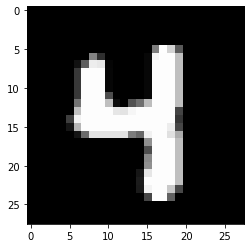

In [6]:
from scipy.signal import convolve
img_ind=58
img = mnist_data_train[img_ind][0][0,:]
plt.imshow(img, vmin=0, vmax=1,cmap="gray")

Dimension of filter:  (3, 3)


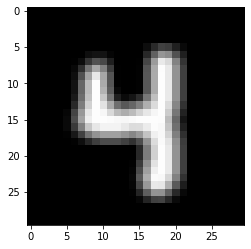

In [13]:
blur_filter = np.asarray([[1,1,1],
                          [1,1,1],
                          [1,1,1]
                          ])/9.0
print("Dimension of filter: ", blur_filter.shape)
blurry_img = convolve(img, blur_filter)
plt.imshow(blurry_img, vmin=0, vmax=1, cmap="gray")
plt.show()

To perform edge detection (here outlines of 4), we want to cancel out everything in the same area, which results in no output, in cases where the neighbor pixels are identical.

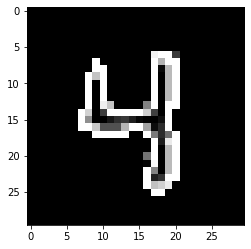

In [27]:
edge_kernel = np.asarray([[-1,-1,-1],
                          [-1,8,-1],
                          [-1,-1,-1]])
edge_img = convolve(img, edge_kernel)
plt.imshow(edge_img, vmin=0, vmax=1, cmap="gray")

The filter is maximized at the edges, since there is the largest change. Outside of the four, there is no response(black), because the high center cancel out the other around it.
The following filter is a slightly modified kernel and not as good at detecting edges.

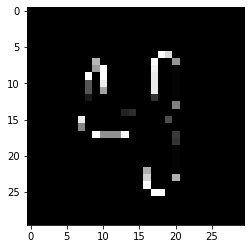

In [29]:
edge_kernel_2= np.asarray([[-1,-1,-1],
                          [-1,6,-1],
                          [-1,-1,-1]])
edge_img = convolve(img, edge_kernel_2)
plt.imshow(edge_img, vmin=0, vmax=1, cmap="gray")

Befor continuing I would like to understand what the convolve function does.
It (discrete convolution) is simply defined by 
$$(a*v)_n = \sum_{m = -\infty}^{\infty}a_m v_{n-m}$$
Where $N, M$ are the lengths of vector $a$ and $v$ respectively.
The above formula tells us how to geht the n-th value of the convolution, of course a generalization to multiple dimensions is also possible. When doing a full convolution, the outputs will have size (N+M-1).

Visually speaking, when doing a convolution on a one dimensional array, the second array is flipped, and then both arrays are slided across each other. The overlapping parts are multiplied and then summed.

Therfore, given two vectors $a = (1,2)'$ and $v= (0,1)'$ a convolution of the two can be constructed. We first flip $v_f = (1,0)'$ then we slide them both across each other. 
Since we do a full convolution, the resulting convolution has the size $N+M-1$

$$(a*v)_1 =\\
(a*v)_2 \\
(a*v)_3$$


 $n=(N+M-1)$ size
$$(a*v)_1 = \sum_{m = 1}^{2}a_m v_{1-m} = a_1 v_0 + a_2 v_1 = a_2 v_1 = 2\cdot 0 = 0\\
(a*v)_2 = \sum_{m = 1}^{2}a_m v_{2-m} = a_1 v_ + a_2 v_0 \\
(a*v)_3 = \sum_{m = 1}^{2}a_m v_{3-m} = a_1 v_2 + a_2 v_1 = 1*1 + 2*0$$


In [33]:
np.convolve([1, 2], [0, 1])
## stopd at 3.4, however still in the process of understanding  convolutions mathematically.

array([0, 1, 2])